# Data Management

Welcome to the Data Management lab!

In previous labs, you focused on building and training models with well-structured data. However, in the real world, data is rarely perfect. Even the most powerful model architecture can fail if it's fed a messy, inefficient, or unreliable data stream. This is where a robust **data pipeline** becomes essential.

This lab shifts your focus from the model to the data itself, tackling the common challenges of real-world datasets. You'll be working with the **[Oxford 102 Flowers dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/)**, a collection of images and labels that are stored in separate files, with inconsistent formatting, and possibly even some corrupted samples. To overcome these hurdles, you will use PyTorch's core data management tools: The **`Dataset`** and **`DataLoader`** classes.

In this lab, you will:

* Explore a real-world dataset with unorganized files and separated labels.
* Build a custom PyTorch **`Dataset`** to load and preprocess images and labels on-the-fly.
* Apply **transformations** and **data augmentation** to prepare your data and improve model robustness.
* Use the **`DataLoader`** to efficiently create and shuffle batches for training.
* Split your data into training, validation, and test sets.
* Implement error-handling techniques to manage data issues and monitor your pipeline’s performance.

## Imports

In [1]:
import os
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import requests
import scipy
from PIL import Image
from torch.utils.data import Dataset, Subset, random_split, DataLoader
from torchvision import transforms

import helper_utils

c:\Users\TECH MOON\Desktop\Home_Practice\Pytorch_DLAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Access

Every deep learning project starts with data, but not all data is ready to use.  
Sometimes it’s already well organized, but often it’s scattered or stored in formats that aren’t directly compatible with model training.
In this section, you’ll learn how to manage data access and follow best practices for working with unorganized or inconsistent datasets.

### Dataset Exploration


The first step when working with a new dataset is to access and explore its structure.
This helps you understand how the data is organized, and therefore, how to load and use it effectively.

* You will define a  `download_dataset` function that downloads the dataset from a given URL and extracts it to a specified directory.
* In this case, the dataset consists of two files: a `.tgz`  file with images and a `.mat` file containing the labels.

Both files will be downloaded using the `requests` library and then extracted using the `tarfile` library.

In [2]:
from tqdm import tqdm

In [3]:
def download_dataset():
    """
    Downloads and extracts a dataset from remote URLs if not already present locally.

    This function first checks for the existence of the dataset files in a specific
    directory. If the files are not found, it proceeds to download them from
    pre-defined URLs, showing progress bars, and then extracts the contents.
    """
    # Define the directory to store the dataset.
    data_dir = "flower_data"
    
    # Define paths for key files and folders.
    image_folder_path = os.path.join(data_dir, "jpg")
    labels_file_path = os.path.join(data_dir, "imagelabels.mat")
    tgz_path = os.path.join(data_dir, "102flowers.tgz")

    # Check if the primary data folder and a key label file already exist.
    if os.path.exists(image_folder_path) and os.path.exists(labels_file_path):
        # Inform the user that the dataset is already available locally.
        print(f"Dataset already exists. Loading locally from '{data_dir}'.")
        # Exit the function since no download is needed.
        return

    # Inform the user that the dataset is not found and the download will start.
    print("Dataset not found locally. Downloading...")

    # Define the URLs for the image archive and the labels file.
    image_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
    labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

    # Create the target directory for the dataset, if it doesn't already exist.
    os.makedirs(data_dir, exist_ok=True)

    # Announce the start of the image download process.
    print("Downloading images...")
    # Send an HTTP GET request to the image URL, enabling streaming for large files.
    response = requests.get(image_url, stream=True)
    # Get the total size of the file from the response headers for the progress bar.
    total_size = int(response.headers.get("content-length", 0))

    # Open a local file in binary write mode to save the downloaded archive.
    with open(tgz_path, "wb") as file:
        # Iterate over the response content in chunks with a progress bar.
        for data in tqdm(
            # Define the chunk size for iterating over the content.
            response.iter_content(chunk_size=1024),
            # Set the total for the progress bar based on the file size in kilobytes.
            total=total_size // 1024,
        ):
            # Write each chunk of data to the file.
            file.write(data)

    # Announce the start of the file extraction process.
    print("Extracting files...")
    # Open the downloaded tar.gz archive in read mode.
    with tarfile.open(tgz_path, "r:gz") as tar:
        # Extract all contents of the archive into the target directory.
        tar.extractall(data_dir)

    # Announce the start of the labels download process.
    print("Downloading labels...")
    # Send an HTTP GET request to the labels URL.
    response = requests.get(labels_url)
    # Open a local file in binary write mode to save the labels.
    with open(labels_file_path, "wb") as file:
        # Write the entire content of the response to the file.
        file.write(response.content)

    # Inform the user that the download and extraction are complete.
    print(f"Dataset downloaded and extracted to '{data_dir}'.")

In [4]:
# Call the function to download and prepare the dataset.
download_dataset()

Dataset already exists. Loading locally from 'flower_data'.


In [5]:
# Define the path to the root directory of the dataset.
path_dataset = './flower_data'

# Display the folder structure of the dataset directory up to a depth of one.
helper_utils.print_data_folder_structure(path_dataset, max_depth=1)

flower_data/
├── 102flowers.tgz
├── imagelabels.mat
├── jpg/
└── labels_description.txt


<br>

You can see that the dataset consists of:
- A  `jpg` folder containing images in JPEG format
- An `imagelabels.mat` file that stores the labels (MATLAB format)
- A `labels_description.txt` file describing each label

This gives you a clear sense of how the dataset is structured and what you’ll be working with.

### Creating a Custom Dataset Class

Having downloaded and briefly explored the dataset, the next step is to create a custom dataset class that organizes access to the data. The goal is to retrieve images and their corresponding labels consistently and efficiently for model training.

You will create a class `FlowerDataset` that inherits from `torch.utils.data.Dataset`.
A custom dataset class *must* implement the following methods:

> `__init__`: Initializes the dataset object.
> * Typically accepts the data path and any transforms to apply.
> * Optionally loads metadata or labels associated with the data.

> `__len__`: Returns the number of samples in the dataset.

> `__getitem__`: Retrieves a single sample given an index.
> * Loads the image and its label, applies transforms, and returns them.

Additionally, you will define helper methods to make the code cleaner and more organized:

> `load_and_correct_labels`: Loads image labels from the MATLAB .mat file.
> * It uses `scipy.io.loadmat` to read the file and extract the labels array.
> * The labels are adjusted by subtracting 1, which is necessary because MATLAB uses 1-based indexing, while Python uses 0-based indexing. 
>    * This correction prevents off-by-one errors during training and evaluation.

> `retrieve_image`: Loads an image from disk given its index `idx`. 
> * Given `idx`, it constructs the filename and path, opens the image using the Pillow library, converts it to RGB format (to ensure consistency), and returns the image object.

> `get_label_description`: Given a label, returns a human-readable description from the text file.

**Regarding lazy loading**:
The images are not loaded all at once when the dataset object is created.
Instead, they are loaded on-the-fly when accessed via the `__getitem__` method.
This approach is memory efficient, especially when dealing with large datasets, as it avoids loading all images into memory at once.

In [6]:
class FlowerDataset(Dataset):
    """
    A custom dataset class for loading flower image data.

    This class is designed to work with PyTorch's Dataset and DataLoader
    abstractions. It handles loading images and their corresponding labels
    from a specific directory structure.
    """
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset object.

        Args:
            root_dir (str): The root directory where the dataset is stored.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # Store the root directory path.
        self.root_dir = root_dir
        # Store the optional transformations.
        self.transform = transform
        # Construct the full path to the image directory.
        self.image_dir = os.path.join(self.root_dir, "jpg")
        # Load and process the labels from the corresponding file.
        self.labels = self.load_and_correct_labels()

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        # The total number of samples is the number of labels.
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset at the specified index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image and its label.
        """
        # Retrieve the image for the given index.
        image = self.retrieve_image(idx)

        # Check if a transform is provided.
        if self.transform is not None:
            # Apply the transform to the image.
            image = self.transform(image)

        # Get the label corresponding to the index.
        label = self.labels[idx]

        # Return the processed image and its label.
        return image, label

    def retrieve_image(self, idx):
        """
        Loads a single image from disk based on its index.

        Args:
            idx (int): The index of the image to load.

        Returns:
            PIL.Image.Image: The loaded image, converted to RGB.
        """
        # Construct the image filename based on the index (e.g., 'image_00001.jpg').
        img_name = f"image_{idx + 1:05d}.jpg"
        # Construct the full path to the image file.
        img_path = os.path.join(self.image_dir, img_name)
        # Open the image file.
        with Image.open(img_path) as img:
            # Convert the image to the RGB color space and return it.
            image = img.convert("RGB")
        return image

    def load_and_correct_labels(self):
        """
        Loads labels from a .mat file and adjusts them to be zero-indexed.

        Returns:
            numpy.ndarray: An array of zero-indexed integer labels.
        """
        # Load the MATLAB file containing the labels.
        self.labels_mat = scipy.io.loadmat(
            os.path.join(self.root_dir, "imagelabels.mat")
        )
        # Extract the labels array and correct for zero-based indexing.
        labels = self.labels_mat["labels"][0] - 1
        # Return the processed labels.
        return labels

    def get_label_description(self, label):
        """
        Retrieves the text description for a given label index.

        Args:
            label (int): The integer label.

        Returns:
            str: The corresponding text description of the label.
        """
        # Construct the path to the file containing label descriptions.
        path_labels_description = os.path.join(self.root_dir, "labels_description.txt")
        # Open the label description file for reading.
        with open(path_labels_description, "r") as f:
            # Read all lines from the file.
            lines = f.readlines()
        # Get the description for the specified label and remove leading/trailing whitespace.
        description = lines[label].strip()
        # Return the clean description.
        return description

In [7]:
# Initialize the dataset object, providing the path to the data.
dataset = FlowerDataset(path_dataset)

It is good practice to verify that your dataset class works as expected before using it to train a model.
After creating an instance of the `FlowerDataset` class, you will:

* Check the total number of samples in the dataset using the `len()` function.

In [8]:
# Print the total number of samples in the dataset.
print(f'Number of samples in the dataset: {len(dataset)}\n')

Number of samples in the dataset: 8189



* Retrieve a specific sample using an index.

In [9]:
# Define an index for a sample to retrieve.
sel_idx = 10

# Retrieve the image and label for the selected index.
img, label = dataset[sel_idx]

- Inspect the image size and label.

In [10]:
# Create a string detailing the image's dimensions.
img_size_info = f"Image size: {img.size}"

# Print the image size information along with its corresponding label.
print(f'{img_size_info}, Label: {label}\n')

Image size: (500, 748), Label: 76



* Visualize the image using the helper function `plot_img`.

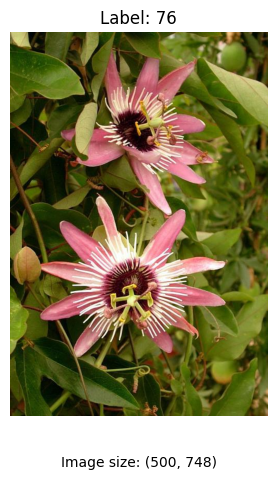

In [11]:
helper_utils.plot_img(img, label=label, info=img_size_info)

<br >

Next, inspect the labels in the dataset. For each unique label, print its corresponding description using the `get_label_description` method.

How are the labels?

In [12]:
# Get all labels from the dataset object.
dataset_labels = dataset.labels

# Create a set of unique labels to remove duplicates.
unique_labels = set(dataset_labels)

# Iterate through each unique label.
for label in unique_labels:
    # Print the numerical label and its corresponding text description.
    print(f'Label: {label}, Description: {dataset.get_label_description(label)}')

Label: 0, Description: 'pink primrose'
Label: 1, Description: 'hard-leaved pocket orchid'
Label: 2, Description: 'canterbury bells'
Label: 3, Description: 'sweet pea'
Label: 4, Description: 'english marigold'
Label: 5, Description: 'tiger lily'
Label: 6, Description: 'moon orchid'
Label: 7, Description: 'bird of paradise'
Label: 8, Description: 'monkshood'
Label: 9, Description: 'globe thistle'
Label: 10, Description: 'snapdragon'
Label: 11, Description: "colt's foot"
Label: 12, Description: 'king protea'
Label: 13, Description: 'spear thistle'
Label: 14, Description: 'yellow iris'
Label: 15, Description: 'globe-flower'
Label: 16, Description: 'purple coneflower'
Label: 17, Description: 'peruvian lily'
Label: 18, Description: 'balloon flower'
Label: 19, Description: 'giant white arum lily'
Label: 20, Description: 'fire lily'
Label: 21, Description: 'pincushion flower'
Label: 22, Description: 'fritillary'
Label: 23, Description: 'red ginger'
Label: 24, Description: 'grape hyacinth'
Labe

### Overview of the Images in the Dataset


Now that you have a working dataset class, you can explore the images in the dataset. You will make use of the `visual_exploration` function to visualize a few images to get a better understanding of the data.

In [13]:
def visual_exploration(dataset, num_rows=2, num_cols=4):
    """
    Displays a grid of randomly selected samples from a dataset for visual inspection.

    Args:
        dataset: The dataset object from which to draw samples. It should support
                 indexing and have a `get_label_description` method.
        num_rows (int): The number of rows in the display grid.
        num_cols (int): The number of columns in the display grid.
    """
    # Calculate the total number of images to display in the grid.
    total_samples = num_rows * num_cols

    # Select a random set of unique indices from the dataset.
    indices = np.random.choice(len(dataset), total_samples, replace=False)

    # Create a grid of subplots to hold the images.
    fig, axes = helper_utils.get_grid(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 4))

    # Iterate over each subplot axis and the corresponding random sample index.
    for ax, idx in zip(axes.flatten(), indices):
        # Retrieve the image and its numerical label from the dataset.
        image, label = dataset[idx]

        # Get the human-readable text description for the label.
        description = dataset.get_label_description(label)

        # Format a new label string that includes both the number and description.
        label = f"{label} - {description}"

        # Create an information string with the sample's index and image dimensions.
        info = f"Index: {idx} Size: {image.size}"

        # Plot the image on the current subplot with its label and info.
        helper_utils.plot_img(image, label=label, info=info, ax=ax)

    # Render and display the entire grid of images.
    plt.show()

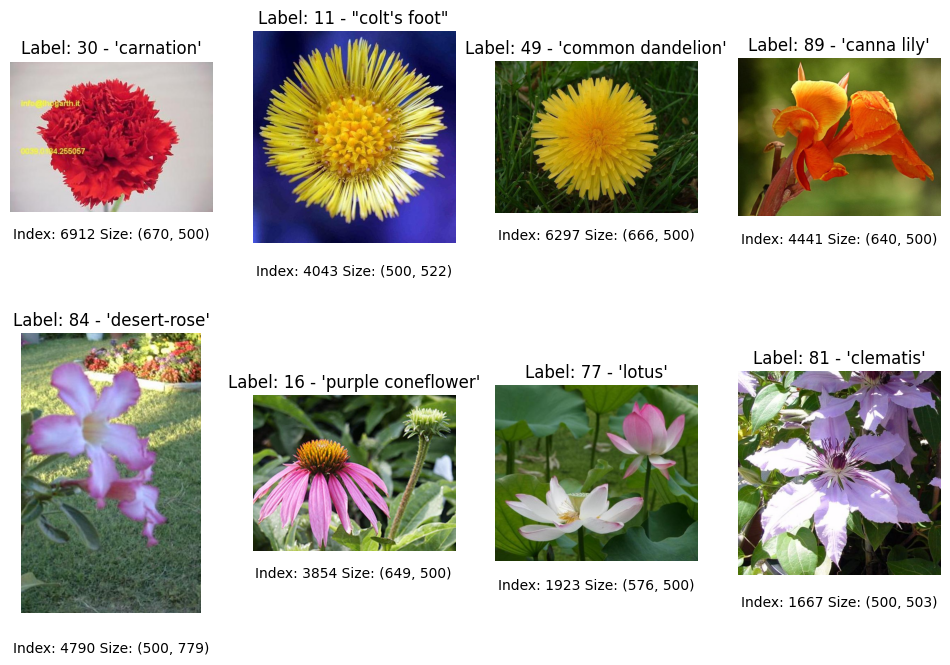

In [14]:
# Display a 2x4 grid of random samples from the dataset for visual inspection.
visual_exploration(dataset, num_rows=2, num_cols=4)

## Quality Problems

As you have seen in the previous section, the size of the images in the dataset varies significantly. This can be a problem when training a model, as most models expect input images to have the same size. To address this issue, you will implement a series of transformations to standardize the size of the images.

### Transformations

After exploring the dataset and identifying potential quality issues, the next step is to apply transformations to preprocess the images.
Transformations are operations that modify images to prepare them for model training. Common examples include resizing, cropping, flipping, and normalizing pixel values.
The `torchvision.transforms` module provides a variety of pre-defined transformations that can be easily applied to images.

You’ll start by defining a simple transformation pipeline composed of two stages:

Transformations **applied directly to the raw images**:
- `Resize((256, 256))`: Resizes each image to a fixed size of 256×256 pixels.
- `CenterCrop(224)`: Crops the center of the image to 224×224 pixels.

Transformations that **convert and standardize images**:
- `ToTensor()`: converts a PIL Image or NumPy array to a tensor and scales pixel values to the range [0, 1].
- `Normalize(mean, std)`: normalizes the tensor using the specified mean and standard deviation.

**Note**: 
The order of transformations often matters. Resizing and cropping should be applied before converting the image to a tensor.

In [15]:
# Define the mean values for normalization.
mean = [0.485, 0.456, 0.406]
# Define the standard deviation values for normalization.
std = [0.229, 0.224, 0.225]

In [16]:
transform = transforms.Compose([
    # images transforms
    transforms.Resize((256, 256)),  # Resize images to 256x256 pixels
    transforms.CenterCrop(224),  # Center crop to 224x224 pixels
    # bridge to tensor
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    # tensor transforms
    transforms.Normalize(mean=mean, std=std),
])

You will now create a new instance of the `FlowerDataset` class, this time passing the transformation pipeline `transform` as an argument.

In [17]:
# Create a new dataset instance with the specified image transformations.
dataset_transformed = FlowerDataset(path_dataset, transform=transform)

Inspect the same sample again to see the effect of the transformations. Using `quick_debug`, you can see that the image has been resized and cropped to 224x224 pixels, and its pixel values have been normalized.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


Shape: torch.Size([3, 224, 224])
Type: torch.float32
Range of pixel values: [-2.1, 2.6]


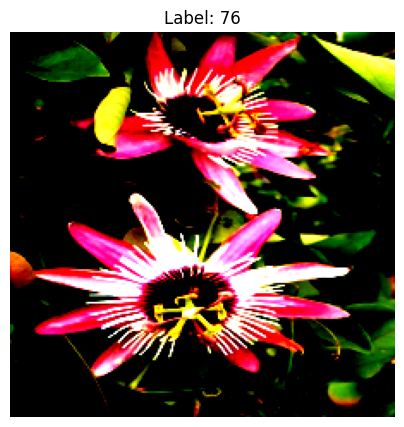

In [18]:
# Retrieve the transformed image and its label using the same index.
img_transformed, label = dataset_transformed[sel_idx]

# quick check
helper_utils.quick_debug(img_transformed)

# Plot the transformed image
helper_utils.plot_img(img_transformed, label=label)

<br>

Observe that the image is now a tensor with shape `[3, 224, 224]` representing 3 color channels (RGB) and 224×224 pixels.
Because the pixel values have been normalized, they are no longer in the original range of [0, 255].

That’s why the image looks different when visualized directly.
To display it correctly, you need to *denormalize* it first. You can do this by applying the `Normalize` transformation again, using `new_mean` and `new_std` values to reverse the normalization process.

In [19]:
class Denormalize:
    """
    A callable class to reverse the normalization of a tensor image.

    This class calculates the inverse transformation of a standard normalization
    and can be used as a transform step, for instance, to visualize images
    after they have been normalized for a model.
    """
    def __init__(self, mean, std):
        """
        Initializes the denormalization transform.

        Args:
            mean (list or tuple): The mean values used for the original normalization.
            std (list or tuple): The standard deviation values used for the original
                                 normalization.
        """
        # Calculate the adjusted mean for the denormalization process.
        new_mean = [-m / s for m, s in zip(mean, std)]
        # Calculate the adjusted standard deviation for the denormalization process.
        new_std = [1 / s for s in std]
        # Create a Normalize transform object with the inverse parameters.
        self.denormalize = transforms.Normalize(mean=new_mean, std=new_std)

    def __call__(self, tensor):
        """
        Applies the denormalization transform to a tensor.

        Args:
            tensor: The normalized tensor to be denormalized.

        Returns:
            The denormalized tensor.
        """
        # Apply the denormalization transform to the input tensor.
        return self.denormalize(tensor)

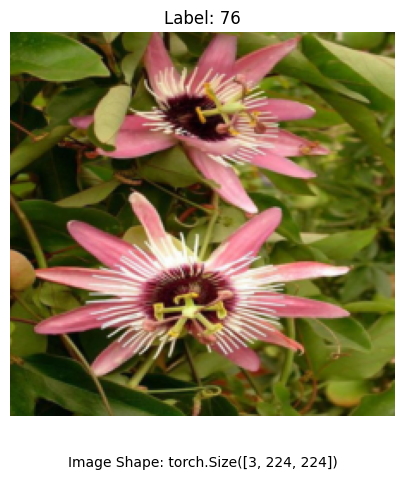

In [20]:
# Create an instance of the Denormalize class with the original mean and std.
denormalize = Denormalize(mean=mean, std=std)
# Apply the denormalization transform to the image tensor.
img_tensor = denormalize(img_transformed)

# Create an information string with the tensor's shape.
img_shape_info = f"Image Shape: {img_tensor.size()}"
# Plot the denormalized image to visualize the result.
helper_utils.plot_img(img_tensor, label=label, info=img_shape_info)

## Data Loading


In this section, you’ll learn how to prepare and serve data efficiently for model training in PyTorch.
A full training process typically includes three stages: training, validation, and evaluation.

During training, the model learns from the training data by adjusting its weights based on the loss function. 
During validation, the model is evaluated on a separate dataset to tune hyperparameters and prevent overfitting.
During evaluation, the model’s performance is tested on unseen data to assess its generalization ability.

Each of these stages requires splitting the dataset into distinct subsets and using data loaders to feed data efficiently during training and testing. In what follows, you will see how to do this using PyTorch.

### Splitting the Dataset

The `split_dataset` function will divide the dataset into training, validation, and test sets.
To do this, you will:

* Define the sizes of each subset from the given fractions for validation and test,
* Make use of `random_split` from `torch.utils.data` to perform the actual split.

In [21]:
def split_dataset(dataset, val_fraction=0.15, test_fraction=0.15):
    """
    Split the dataset into training, validation, and test sets.
    
    By default, this function splits the data into 70% for training,
    15% for validation, and 15% for testing.
    """

    # Calculate the sizes of each split.
    total_size = len(dataset)
    val_size = int(total_size * val_fraction)
    test_size = int(total_size * test_fraction)
    train_size = total_size - val_size - test_size

    # Use random_split to create the datasets.
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    return train_dataset, val_dataset, test_dataset

In [22]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset_transformed)

Check the sizes of the resulting datasets to ensure they match the expected proportions.

In [23]:
print(f"Length of training dataset:   {len(train_dataset)}")
print(f"Length of validation dataset: {len(val_dataset)}")
print(f"Length of test dataset:       {len(test_dataset)}")

Length of training dataset:   5733
Length of validation dataset: 1228
Length of test dataset:       1228


### Dataloaders

Once your dataset is split into training, validation, and test sets, the next step is to serve data efficiently to your model during training and evaluation. 
PyTorch’s `DataLoader` class handles this by batching samples, shuffling data during training, and simplifying iteration over your dataset.
Using dataloaders helps speed up training and ensures your model sees a diverse mix of samples in each batch.
Now you will create dataloaders for each subset of the data (training, validation, and test).
You will use the `DataLoader` class from `torch.utils.data` to create dataloaders.
The arguments you will provide include:
- `dataset`: The dataset to load data from (e.g., `train_dataset`, `val_dataset`, `test_dataset`),
- `batch_size`: The number of samples per batch to load (e.g., `32`),
- `shuffle`: Whether to shuffle the data at every epoch (typically `True` for training and `False` for validation and test).

In [24]:
# Set the batch size for the data loaders.
batch_size = 32

# Create the DataLoader for the training set, with shuffling enabled.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create the DataLoader for the validation set, with shuffling disabled.
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Create the DataLoader for the test set, with shuffling disabled.
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

To understand how dataloaders work, you can iterate for two epochs over the training and validation dataloaders and, at the very end, iterate over the test dataloader.
This will give you a sense of how data is served in batches during training and evaluation.

In [25]:
# Define the total number of training epochs.
n_epochs = 2

In [26]:
# Start the main training loop for each epoch.
for epoch in range(n_epochs):
    # Print a header to indicate the start of a new epoch.
    print(f"=== Processing epoch {epoch} ===")

    # Announce the start of the training phase.
    print(f"Pass number {epoch} through the training set")
    print('Training...')
    # Get the total number of samples in the training set.
    train_samples = len(train_dataset)
    # Create a progress bar for the training data loader.
    train_bar = helper_utils.get_dataloader_bar(train_dataloader, color='blue')
    
    # Iterate over the training data loader to get batches of images and labels.
    for batch, (images, labels) in enumerate(train_dataloader):
        # Update the training progress bar for the current batch.
        helper_utils.update_dataloader_bar(train_bar, batch, batch_size, train_samples)

    # Announce the start of the validation phase.
    print(f"\nPass number {epoch} through the validation set")
    print('Validation...')
    # Create a progress bar for the validation data loader.
    val_bar = helper_utils.get_dataloader_bar(val_dataloader, color='orange')
    # Get the total number of samples in the validation set.
    val_samples = len(val_dataset)
    
    # Iterate over the validation data loader to get batches of images and labels.
    for batch, (images, labels) in enumerate(val_dataloader):
        # Update the validation progress bar for the current batch.
        helper_utils.update_dataloader_bar(val_bar, batch, batch_size, val_samples)

=== Processing epoch 0 ===
Pass number 0 through the training set
Training...
Batch 180:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             , 5733 of a total of  5733 samples
Pass number 0 through the validation set
Validat

c:\Users\TECH MOON\Desktop\Home_Practice\Pytorch_DLAI\.venv\Lib\site-packages\tqdm\std.py:161: TqdmWarning: Unknown colour (orange); valid choices: [hex (#00ff00), BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE]
  self.colour = colour


Batch 180:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             , 5733 of a total of  5733 samples=== Processing epoch 1 ===
Pass number 1 through the training set
Training...

Batch 180:                                      

Batch 39:                                                                                                                                                                                                                                                                                                                                                                                           , 1228 of a total of  1228 samples

In [27]:
# Announce the final evaluation on the test set.
print("\nFinal pass through the test set for evaluation")
# Create a progress bar for the test data loader.
test_bar = helper_utils.get_dataloader_bar(test_dataloader, color='green')
# Get the total number of samples in the test set.
test_samples = len(test_dataset)

# Iterate over the test data loader to get batches of images and labels.
for batch, (images, labels) in enumerate(test_dataloader):
    # Update the test progress bar for the current batch.
    helper_utils.update_dataloader_bar(test_bar, batch, batch_size, test_samples)


Final pass through the test set for evaluation


<br>
You can observe that the training dataloader has a total of 180 batches (for a total of 5733 samples). The validation and test dataloaders each have 39 batches (for a total of 1228 samples each).

## Augmentation


Data augmentation is an important technique for improving the robustness and generalization of deep learning models.
By applying random transformations, such as flipping, rotating, or adjusting brightness, to training images, augmentation helps models recognize objects under varied real-world conditions. 

In PyTorch, augmentation can be performed "on-the-fly," generating endless image variations without extra storage. 

Within `get_augmentation_transform`, you’ll create a more advanced transformation pipeline that includes data augmentation techniques.
This pipeline consists of the following:

Transformations that augment the raw images:
- `RandomHorizontalFlip(p=0.5)`: This transformation randomly flips the image horizontally with a probability of 0.5,
- `RandomRotation(degrees=10)`: This transformation randomly rotates the image within a range of -10 to +10 degrees,
- `ColorJitter(brightness=0.2)`: This transformation randomly changes the brightness, contrast, saturation, and hue of the image.

Transformations that standardize the images as `transform`: `Resize`, `CenterCrop`, `ToTensor`, and `Normalize`.

You then create a new instance of the `FlowerDataset` class, this time passing the augmentation transformation pipeline `augmentation_transform` as an argument.

In [ ]:
def get_augmentation_transform(mean, std):
    """
    Creates and returns a composition of image transformations for data augmentation
    and preprocessing.

    Args:
        mean (list or tuple): A sequence of mean values for each channel.
        std (list or tuple): A sequence of standard deviation values for each channel.

    Returns:
        torchvision.transforms.Compose: A composed pipeline of transformations.
    """
    # Define a list of data augmentation transformations to be applied randomly.
    augmentations_transforms = [
        # Randomly flip the image horizontally with a 50% probability.
        transforms.RandomHorizontalFlip(p=0.5),
        # Randomly rotate the image within a range of +/- 10 degrees.
        transforms.RandomRotation(degrees=10),
        # Randomly adjust the brightness of the image.
        transforms.ColorJitter(brightness=0.2),
    ]
    
    # Define the main list of standard, non-random transformations.
    main_transforms = [
        # Resize the input image to 256x256 pixels.
        transforms.Resize((256, 256)),
        # Crop the center 224x224 pixels of the image.
        transforms.CenterCrop(224),
        # Convert the PIL Image to a PyTorch tensor.
        transforms.ToTensor(),
        # Normalize the tensor with the provided mean and standard deviation.
        transforms.Normalize(mean=mean, std=std),
    ]

    # Combine the augmentation and main transformations into a single pipeline.
    transform = transforms.Compose(augmentations_transforms + main_transforms)
    # Return the final composed transform object.
    return transform

In [29]:
# Create the augmentation and preprocessing pipeline, providing the normalization stats.
augmentation_transform = get_augmentation_transform(mean=mean, std=std)

# Initialize a new dataset instance that will use the augmentation pipeline.
dataset_augmented = FlowerDataset(path_dataset, transform=augmentation_transform)

Debugging a dataset pipeline is a relevant step to ensure that the transformations and data loading processes are functioning as intended.
`visualize_augmentation` allows you to visualize the effect of the augmentation transformations on a sample image. 

For a given number of versions, it retrieves the same sample image from the dataset. As the dataset applies random transformations, each retrieved version of the image will be affected differently, allowing you to see the variety of augmentations applied.

In [30]:
def visualize_augmentations(dataset_aug, idx=0, num_versions=8):
    """
    Displays multiple augmented versions of a single image from a dataset.

    This function repeatedly retrieves an image from a dataset with augmentations
    enabled, then displays each unique, randomly generated version in a grid
    to help visualize the effect of the transformations.

    Args:
        dataset_aug: The dataset object with augmentation transforms applied.
        idx (int): The index of the image in the dataset to visualize.
        num_versions (int): The total number of augmented versions to display.
    """
    # Create a denormalization transform to revert normalization for display.
    denormalize = Denormalize(mean, std)

    # Set the number of rows for the visualization grid.
    n_rows = 2
    # Calculate the number of columns needed based on the total versions to show.
    n_cols = num_versions // n_rows
    # Create a grid of subplots to display the images.
    fig, axes = helper_utils.get_grid(n_rows, n_cols, figsize=(16, 8))

    # Iterate through each subplot axis in the grid.
    for ax in axes.flatten():
        # Get a new, randomly augmented version of the same image by index.
        img, label = dataset_aug[idx]

        # Denormalize the image tensor so it can be displayed correctly.
        img = denormalize(img)

        # Plot the augmented image on the current subplot.
        helper_utils.plot_img(img=img, ax=ax)

    # Display the complete grid of augmented images.
    plt.show()

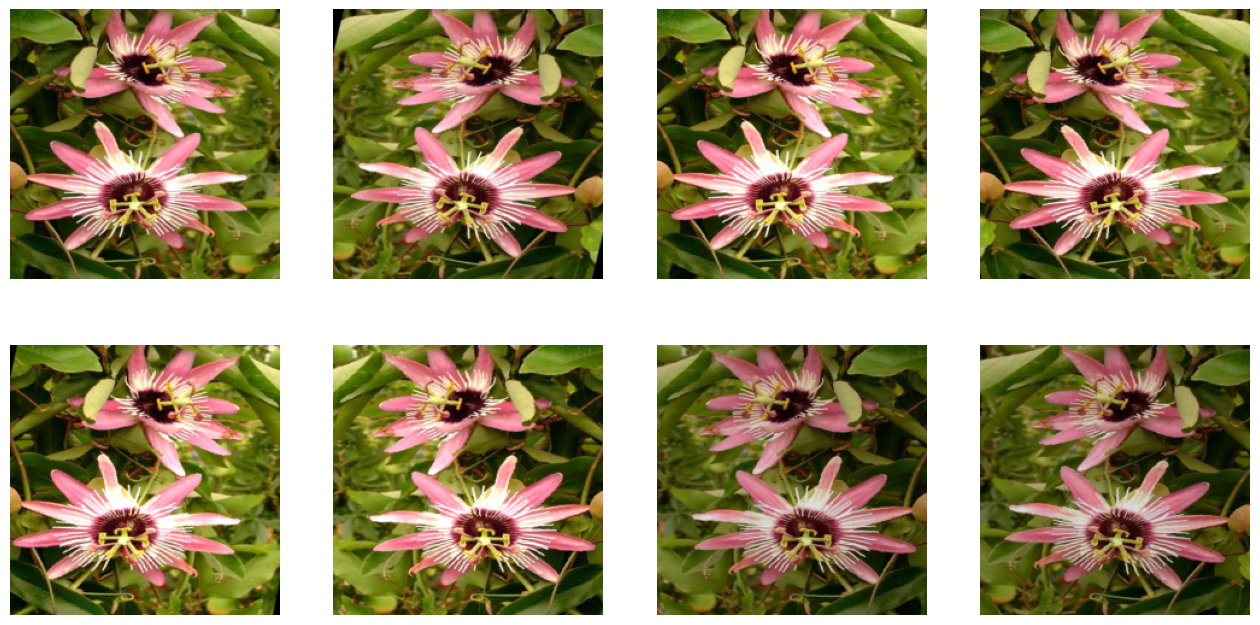

In [31]:
# Display 8 augmented versions of the selected image to see the transformations.
visualize_augmentations(dataset_augmented, idx=sel_idx, num_versions=8)

### Splitting with Augmentation

Integrating proper random splitting with data augmentation requires careful handling to ensure that the training, validation, and test sets are distinct and that augmentation is applied only to the training data.

One subtle point to consider is that when using `random_split`, each of the splits is a `Subset` object that references the original dataset.
Therefore those subsets will inherit the transformations defined in the original dataset and can not be assigned different transformations directly.

To address this, you will create a custom dataset class `SubsetWithTransform` that wraps around a `Subset` and allows you to specify a different transformation for it.

In [32]:
class SubsetWithTransform(Dataset):
    """
    A wrapper for a PyTorch Subset that applies a specific transformation.

    This class allows for applying a different set of transformations to a
    subset of a dataset, which is useful for creating distinct training,
    validation, or test sets with different preprocessing steps from the
    same base dataset.
    """
    def __init__(self, subset, transform=None):
        """
        Initializes the SubsetWithTransform object.

        Args:
            subset: A PyTorch Subset object containing a portion of a dataset.
            transform (callable, optional): An optional transform to be applied
                to the samples within this subset.
        """
        # Store the original subset of the dataset.
        self.subset = subset
        # Store the transformations to be applied.
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the subset.
        """
        # Return the length of the underlying subset.
        return len(self.subset)

    def __getitem__(self, idx):
        """
        Retrieves a sample and applies the transform.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the transformed image and its label.
        """
        # Get the original image and label from the underlying subset.
        image, label = self.subset[idx]
        # Check if a transform has been provided.
        if self.transform:
            # Apply the transform to the image.
            image = self.transform(image)
        # Return the transformed image and its label.
        return image, label

In [33]:
# Apply the augmentation pipeline to the training subset.
train_dataset = SubsetWithTransform(train_dataset, transform=augmentation_transform)
# Apply the basic preprocessing transform to the validation subset.
val_dataset = SubsetWithTransform(val_dataset, transform=transform)
# Apply the basic preprocessing transform to the test subset.
test_dataset = SubsetWithTransform(test_dataset, transform=transform)

You can check that indeed the training dataset has the augmentation transformations applied, while the validation and test datasets do not.

In [34]:
print(train_dataset.transform)
print(val_dataset.transform)
print(test_dataset.transform)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=None, saturation=None, hue=None)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Robust Datasets


In real-world projects, data pipelines must be resilient to unexpected issues such as corrupted files, inconsistent image formats, or problematic samples that can crash training runs. 
This section introduces robust dataset design strategies.

### Error Handling


You will create a new custom dataset class `RobustFlowerDataset` that extends the original `FlowerDataset` class to handle potential issues with corrupted or problematic images.

The `__init__`, `__len__` and `load_and_correct_labels` methods remain mostly the same as in the original `FlowerDataset` class.

The main differences are:

> `__getitem__`: Implements a try-except block to catch exceptions that may occur when loading an image.
> * If an exception occurs (e.g., due to a corrupted image file), the code will print and log the error by calling the `log_error` method. 
> * It then attempts to retrieve the next image in the dataset instead of stopping execution.

> `retrieve_image`: Handles the actual image loading process. 
> * Constructs the filename and path, verifies image integrity using Pillow’s `verify()` method, and reloads the image to ensure it is fully loaded into memory.
> * Checks the image size, raising an error if it’s smaller than 32 pixels in either dimension, and converts grayscale images to RGB for consistency.

> `get_error_summary`: Provides a summary of all errors encountered during data loading, useful for debugging and assessing dataset quality.

In [35]:
class RobustFlowerDataset(Dataset):
    """
    A custom dataset class with robust error handling for loading images.

    This class is designed to gracefully handle issues with individual data
    samples, such as corrupted files or incorrect formats. It logs any errors
    and attempts to load a different sample instead of crashing.
    """
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset object.

        Args:
            root_dir (str): The root directory where the dataset is stored.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # Store the root directory path.
        self.root_dir = root_dir
        # Construct the full path to the image directory.
        self.img_dir = os.path.join(root_dir, "jpg")
        # Store the optional transformations.
        self.transform = transform
        # Load and process the labels from the corresponding file.
        self.labels = self.load_and_correct_labels()
        # Initialize a list to keep track of any errors encountered.
        self.error_logs = []

    def __getitem__(self, idx):
        """
        Retrieves a sample, handling errors by trying the next available item.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image and its label.
        """
        # Loop to attempt loading a valid sample, preventing an infinite loop.
        for attempt in range(len(self)):
            # Attempt to load and process the sample.
            try:
                # Retrieve the image using the helper method.
                image = self.retrieve_image(idx)
                # Check if a transform has been provided.
                if self.transform:
                    # Apply the transform to the image.
                    image = self.transform(image)
                # Get the label for the current index.
                label = self.labels[idx]
                # Return the valid image and its corresponding label.
                return image, label
            # Catch any exception that occurs during the process.
            except Exception as e:
                # Log the error with its index and message.
                self.log_error(idx, e)
                # Move to the next index, wrapping around if necessary.
                idx = (idx + 1) % len(self)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        # The total number of samples is the number of labels.
        return len(self.labels)

    def retrieve_image(self, idx):
        """
        Loads and validates a single image from disk.

        Args:
            idx (int): The index of the image to load.

        Returns:
            PIL.Image.Image: The validated and loaded image object.
        """
        # Construct the image filename based on the index.
        img_name = f"image_{idx+1:05d}.jpg"
        # Construct the full path to the image file.
        img_path = os.path.join(self.img_dir, img_name)
        # Open the image file to check its integrity without loading fully.
        with Image.open(img_path) as img:
            # Perform a quick verification of the file's structure.
            img.verify()
        # Re-open the image file after successful verification.
        image = Image.open(img_path)
        # Fully load the image data into memory.
        image.load()
        # Check if the image dimensions are below a minimum threshold.
        if image.size[0] < 32 or image.size[1] < 32:
            # Raise an error for images that are too small.
            raise ValueError(f"Image too small: {image.size}")
        # Check if the image is not in the RGB color mode.
        if image.mode != "RGB":
            # Convert the image to RGB.
            image = image.convert("RGB")
        # Return the fully loaded and validated image.
        return image

    def load_and_correct_labels(self):
        """
        Loads labels from a .mat file and adjusts them.

        Returns:
            numpy.ndarray: An array of zero-indexed integer labels.
        """
        # Load the MATLAB file containing the labels.
        self.labels_mat = scipy.io.loadmat(
            os.path.join(self.root_dir, "imagelabels.mat")
        )
        # Extract the labels array and correct for zero-based indexing.
        labels = self.labels_mat["labels"][0] - 1
        # Truncate the dataset to the first 10 labels for quick testing.
        labels = labels[:10]
        # Return the processed labels.
        return labels

    def log_error(self, idx, e):
        """
        Records the details of an error encountered during data loading.

        Args:
            idx (int): The index of the problematic sample.
            e (Exception): The exception object that was raised.
        """
        # Construct the filename of the problematic image.
        img_name = f"image_{idx + 1:05d}.jpg"
        # Construct the full path to the image file.
        img_path = os.path.join(self.img_dir, img_name)
        # Append a dictionary with error details to the log.
        self.error_logs.append(
            {
                "index": idx,
                "error": str(e),
                "path": img_path if "img_path" in locals() else "unknown",
            }
        )
        # Print a warning to the console about the skipped image.
        print(f"Warning: Skipping corrupted image {idx}: {e}")

    def get_error_summary(self):
        """
        Prints a summary of all errors encountered during dataset processing.
        """
        # Check if the error log is empty.
        if not self.error_logs:
            # Print a message indicating the dataset is clean.
            print("No errors encountered - dataset is clean!")
        else:
            # Print the total number of problematic images found.
            print(f"\nEncountered {len(self.error_logs)} problematic images:")
            # Iterate through the first few logged errors.
            for error in self.error_logs[:5]:
                # Print the details of an individual error.
                print(f"  Index {error['index']}: {error['error']}")
            # Check if there are more errors than were displayed.
            if len(self.error_logs) > 5:
                # Print a summary of the remaining errors.
                print(f"  ... and {len(self.error_logs) - 5} more")

The Oxford Flowers 102 dataset is clean, but to illustrate robustness techniques, a subset of images in the dataset have been intentionally corrupted. The files of this subset are in the folder `./corrupted_flower_data`.

You can create an instance of the `RobustFlowerDataset` class, passing the path to the corrupted dataset. 

In [36]:
# Define the path to the directory containing the corrupted dataset.
corrupted_dataset_path = './corrupted_flower_data'

# Initialize the robust dataset handler with the path to the corrupted data.
robust_dataset = RobustFlowerDataset(corrupted_dataset_path)

FileNotFoundError: [Errno 2] No such file or directory: './corrupted_flower_data\\imagelabels.mat'

In [ ]:
# Set the index to a known corrupted image. Image 2 is tiny
idx = 2

# Attempt to retrieve the image; the robust dataset will skip the bad one and return the next.
img, label = robust_dataset[idx]

# Plot the retrieved image, which should be the one following the corrupted one.
helper_utils.plot_img(img)

# Explicitly retrieve the next image in the sequence to verify.
next_img, next_label = robust_dataset[idx + 1]

# Plot the next image; it should be identical to the one above.
helper_utils.plot_img(next_img)

In [ ]:
# Set the index to a known grayscale image.
# Image 4 is corrupted (grayscale)
idx = 4

# Reconstruct the path to the original image file.
original_img_path = os.path.join(robust_dataset.img_dir, f"image_{idx + 1:05d}.jpg")
# Open the original image directly to check its mode before correction.
original_img = Image.open(original_img_path)
# Print the mode of the original, uncorrected image.
print(f"Mode of the original image file: {original_img.mode}")  # Prints 'L' for 8-bit grayscale. A standard color image would be 'RGB'.

In [ ]:
# Retrieve the image; the robust loader should automatically convert it to RGB.
img, label = robust_dataset[idx]

# Plot the image to visually confirm it's now in color.
helper_utils.plot_img(img)

# Print the image's mode to confirm it has been corrected to 'RGB'.
print(f"Mode of the corrected image: {img.mode}")

In [ ]:
# Set the index to a known corrupted or unreadable image.
idx = 6

# Attempt to retrieve the image; the robust loader should skip the corrupted file and return the next one.
robust_img = robust_dataset[idx][0]

# Plot the retrieved image, which should be the sample from the next index (7).
helper_utils.plot_img(robust_img)

# Explicitly retrieve the next image in the sequence to verify the fallback logic.
# Check next image to ensure it's correct
next_img, next_label = robust_dataset[idx + 1]

# Plot the next image; it should be identical to the one above, confirming the skip.
helper_utils.plot_img(next_img)

You can see that images 2, 4 and 6 are corrupted in different ways, but the robust dataset class is able to handle those cases accordingly.
You can get a summary of the errors encountered during data loading by inspecting the `error_logs` attribute.

In [ ]:
# Display the summary of any corrupted or problematic images found during loading.
robust_dataset.get_error_summary()

### Tracking Errors

In real-world deep learning projects, data pipelines need to be robust not only to corrupted files but also to subtle issues that can silently degrade model performance.
Beyond handling exceptions, it’s important to systematically track and analyze the errors and anomalies that occur during data loading and preprocessing.

This final section introduces practical strategies for error tracking within your dataset pipeline.
You’ll learn how to log problematic samples, monitor which images are accessed (and how often), and review error summaries after training.
These techniques help ensure that your pipeline is resilient, transparent, and production-ready, allowing you to detect and resolve data quality issues before they affect your model’s results.

The `MonitoredDataset` class extends `RobustFlowerDataset` to add monitoring features for dataset access and loading performance.

- **Access Tracking**: Each time an image is loaded through `__getitem__`, the class increments a counter for that image index in `self.access_counts`. This allows you to track how often each sample is accessed during training or evaluation.

- **Load Time Measurement**: This class records the time taken to load each image and stores these values in `self.load_times`. If loading an image takes longer than 1 second, a warning is printed with the image index and load time. This helps identify slow-loading samples that may affect training performance.

- **Statistics Reporting**: The `print_stats()` method provides a summary of dataset usage, including:
    - Total number of images in the dataset
    - Number of unique images accessed
    - Number of errors encountered (inherited from the parent class)
    - Average and maximum image load times
    - A warning if any images were never accessed, with examples

These monitoring capabilities help you spot bottlenecks, diagnose errors, and ensure the reliability of your data pipeline—making it easier to debug and optimize dataset handling in deep learning workflows.

The MonitoredDataset class extends RobustFlowerDataset to add monitoring features for dataset access and loading performance.

In [ ]:
class MonitoredDataset(RobustFlowerDataset):
    """
    Extends a robust dataset class to add performance monitoring.

    This class tracks metrics such as how frequently each image is accessed,
    how long each access takes, and which images are never loaded. It provides
    a summary of these statistics to help diagnose data pipeline issues.
    """
    def __init__(self, *args, **kwargs):
        """
        Initializes the monitored dataset object.

        Args:
            *args: Variable length argument list passed to the parent class.
            **kwargs: Arbitrary keyword arguments passed to the parent class.
        """
        # Initialize the parent class with all provided arguments.
        super().__init__(*args, **kwargs)
        # Initialize a dictionary to count how many times each index is accessed.
        self.access_counts = {}
        # Initialize a list to store the load time for each access.
        self.load_times = []

    def __getitem__(self, idx):
        """
        Retrieves a sample while monitoring access counts and load times.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: The data sample (e.g., image and label) from the parent class.
        """
        # Import the time module for timing operations.
        import time
        # Record the start time of the operation.
        start_time = time.time()
        # Increment the access count for the given index.
        self.access_counts[idx] = self.access_counts.get(idx, 0) + 1
        # Call the parent class's method to load the data.
        result = super().__getitem__(idx)
        # Calculate the total time taken to load the sample.
        load_time = time.time() - start_time
        # Append the calculated load time to the list.
        self.load_times.append(load_time)
        # Check if the load time exceeds a certain threshold.
        if load_time > 1.0:
            # Print a warning if a slow load time is detected.
            print(f"⚠️ Slow load: Image {idx} took {load_time:.2f}s")
        # Return the loaded sample from the parent class.
        return result

    def print_stats(self):
        """
        Prints a summary of the dataset's access statistics and performance.
        """
        # Print a header for the statistics report.
        print("\n=== Pipeline Statistics ===")
        # Display the total number of images in the dataset.
        print(f"Total images: {len(self)}")
        # Display the number of unique images that were accessed.
        print(f"Unique images accessed: {len(self.access_counts)}")
        # Display the total number of errors logged by the parent class.
        print(f"Errors encountered: {len(self.error_logs)}")
        # Check if any load times have been recorded.
        if self.load_times:
            # Calculate the average load time.
            avg_time = sum(self.load_times) / len(self.load_times)
            # Find the maximum (slowest) load time.
            max_time = max(self.load_times)
            # Print the average load time in milliseconds.
            print(f"Average load time: {avg_time*1000:.1f} ms")
            # Print the slowest load time in milliseconds.
            print(f"Slowest load: {max_time*1000:.1f} ms")
        # Create a set of all possible indices in the dataset.
        all_indices = set(range(len(self)))
        # Create a set of all indices that were actually accessed.
        accessed_indices = set(self.access_counts.keys())
        # Find the set of indices that were never accessed.
        never_accessed = all_indices - accessed_indices
        # Check if there are any images that were never loaded.
        if never_accessed:
            # Print a warning message with the count of never-accessed images.
            print(f"\n⚠️ WARNING: {len(never_accessed)} images were never loaded!")
            # Show a few examples of the indices that were never accessed.
            print(f"   Examples: {list(never_accessed)[:5]}")

In [ ]:
# Initialize the monitored dataset with the path to the potentially corrupted data.
monitored_dataset = MonitoredDataset(corrupted_dataset_path)

# Loop through every index in the dataset to simulate a full pass.
# Iterate through the dataset to trigger monitoring
for idx in range(len(monitored_dataset)):
    # Access the sample at the current index to trigger the monitoring and error-handling logic.
    img, label = monitored_dataset[idx]

In [ ]:
# Print the statistics
monitored_dataset.print_stats()

The `print_stats` method provides a comprehensive overview of the dataset's usage and any issues encountered during data loading.
This is a good practice to implement in your dataset classes, as it helps you monitor the quality of your data and the performance of your data pipeline.

## Conclusion

Congratulations! You’ve now built a complete, production-ready data pipeline in PyTorch.
In this lab, you moved beyond working with perfectly curated data and learned how to manage the real-world complexities of data handling—from initial access to efficient batching.

You saw how to organize a messy dataset by creating a custom **`Dataset`** class to load images and labels from separate files. You applied essential preprocessing steps, including **transformations** to normalize your data and **data augmentation** to make your future model more robust.

You then used  **`DataLoader`** to prepare your data by batching and shuffling it for training. Finally, you made your pipeline more reliable by implementing error handling and performance monitoring, ensuring that your model’s training process is both stable and efficient.

You’ve built a strong foundation in data management that will support everything you do next.